# Plug and Play

#### Imports

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt


import torch
from torchmetrics.image import TotalVariation
from torchmetrics.functional.image import image_gradients

#from metricas import *
from forward.degradation import *
from drunet.network_unet import UNetRes as net

#### Data-loading

In [3]:
model_path = os.path.join('./drunet/drunet_gray.pth')
model = net(in_nc=1+1, out_nc=1, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
for _, v in model.named_parameters():
    v.requires_grad = False

In [4]:
def get_sigma(iter_num=15, modelSigma1=49.0, modelSigma2=2.55, w=1.0):
    '''
    One can change the sigma to implicitly change the trade-off parameter
    between fidelity term and prior term
    '''
    modelSigmaS = np.logspace(np.log10(modelSigma1), np.log10(modelSigma2), iter_num).astype(np.float32)
    modelSigmaS_lin = np.linspace(modelSigma1, modelSigma2, iter_num).astype(np.float32)
    sigmas = (modelSigmaS*w+modelSigmaS_lin*(1-w))/255.
    return sigmas

In [5]:
# convert uint (HxWxn_channels) to 4-dimensional torch tensor
def uint2tensor4(img):
    if img.ndim == 2:
        #agrega una dimension mas al array (600,800) --> (600,800,1)
        img = np.expand_dims(img, axis=2)
        #np.ascontiguousarray(img) guarda todas las entradas de la red en lugares adyacentes en memoria
        #permute cambia las dims (600, 800, 1) --> (1, 600, 800)
        #float() pasa las entradas del array a tipo float
        #div(255.) divide todos los elementos entre 255
        #unsqueeze agrega una dimension en la dim especificada (1, 600, 800) --> (1, 1, 600, 800)
    return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().div(255.).unsqueeze(0)

In [ ]:
image_path = '../Plug&Play/images/VAMO.png'
img = np.asarray(Image.open(image_path))[:,:,0] #solo canal rojo
img = torch.tensor(img, dtype=torch.float32)

In [ ]:
y = forward(img)
y_abs = np.abs(y.detach().numpy())
plt.figure()
plt.imshow(y_abs,cmap='gray')
plt.show()

#### Creation of the model

In [8]:
def minimizeViaTorch(funcion_objetivo, x0, z, mu, sigma, lr=0.1, max_iter=100, eps=1e-6):

    params = x0
    params.requires_grad_()
    optimizer = torch.optim.Adam([params], lr=lr)

    diff = torch.inf

    k = 0

    while (k < max_iter) and (diff > eps):

        print(f"k: {k}, diff: {diff}", end="\r", flush=True)

        params_ant = params.detach().clone()

        optimizer.zero_grad()
        loss = funcion_objetivo(params,z,mu,sigma)
        print('loss = {}'.format(loss))
        loss.backward(retain_graph=True)
        optimizer.step()

        params_sig = params.detach().clone()

        diff = torch.norm(params_sig - params_ant)

        k += 1

    print("\n\n")

    return params.detach().clone()

#### Run model

In [ ]:

#get sigmas for denoiser and constants

noise_level_model =  7.65/255.0
iter_num = 8
modelSigma1 = 49
modelSigma2 = noise_level_model * 255.0
sigma = get_sigma(iter_num=iter_num, modelSigma1=modelSigma1, modelSigma2=modelSigma2, w=1.0)
sigmas = torch.tensor(sigma)

mu = 0
eps = 1e-5
opt_max_iter = 20
lr = 1e-2
diff_x = torch.inf

#initial conditions

z = torch.tensor(y_abs)
y_abs_tensor4 = uint2tensor4((z*255).detach().numpy())
x_0 = torch.cat((y_abs_tensor4, sigmas[2].float().repeat(1, 1, y_abs_tensor4.shape[2], y_abs_tensor4.shape[3])), dim=1)
x_0 = model(x_0)
x_0_uint8 = (255*x_0[0,0,:,:]).to(torch.uint8)
x = x_0_uint8.clone().to(torch.float32).requires_grad_(True)

plt.figure()
plt.imshow(x.detach().numpy(),cmap='gray')
plt.show()

iter = 0
while (iter <= iter_num) and (diff_x > eps):
    print(f"Iteración: {iter}/{iter_num}", end="\r", flush=True)
    print(f"\ndiff_x: {diff_x}") 
    def optimize_x(x,z,mu,sigma):
        #print('reg = {}'.format(mu*sigmas[iter]*torch.norm(x - z)**2))
        T_x = forward(x)
        return torch.norm(y - T_x)**2 + mu*sigma*torch.norm(x/255 - z)**2
    # Actualizacion de x
    x_opt = minimizeViaTorch(optimize_x,x,z,mu,sigmas[iter], lr, opt_max_iter, eps) * 255

    x_opt_tensor4 = uint2tensor4(x_opt.detach().numpy())

    # Actualizacion de z (.predict de red)
    x_next = torch.cat((x_opt_tensor4, sigmas[iter].float().repeat(1, 1, x_opt_tensor4.shape[2], x_opt_tensor4.shape[3])), dim=1)
    z_next = model(x_next)

    # Recalculo diferencia entre actualizaciones
    diff_x = torch.norm(x_next - x)

    # Asigno la actualizacion
    x = x_next[0,0,:,:].clone().to(torch.uint8).to(torch.float32)
    z = z_next[0,0,:,:].clone().to(torch.uint8).to(torch.float32)
    iter = iter + 1
print("\nFin!")

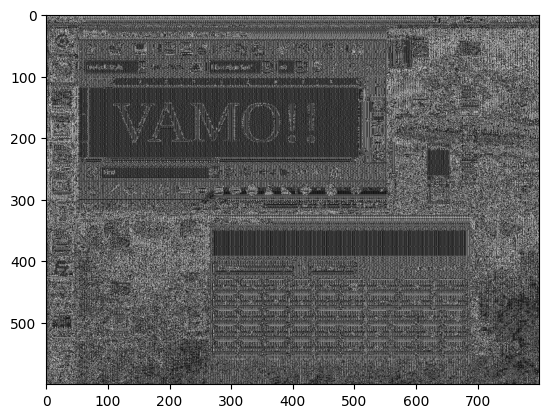

In [ ]:
plt.figure()
plt.imshow(z,cmap='gray')
plt.show()